In this notebook we simply reproduce the advanced regression results in https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset, and submit the model trained on the training data.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Custom import
from sklearn.utils import shuffle

# getting rid of annoying warnings.
import warnings
warnings.filterwarnings('ignore')

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [2]:
# Get data
train = pd.read_csv("train.csv") #shuffle(pd.read_csv("train.csv"))
print("train : " + str(train.shape))
n = train.shape[0]
submit_data = pd.read_csv('test.csv')
#We will work primarily with tot, which contains the training and test data.
tot = pd.concat([train, submit_data], axis = 0)
print(tot.shape)
m = tot.shape[0]
#Let train be the first n rows of tot so that updates are accurately reflected.
train = tot[0:n]

train : (1460, 81)
(2919, 81)


# Preprocessing

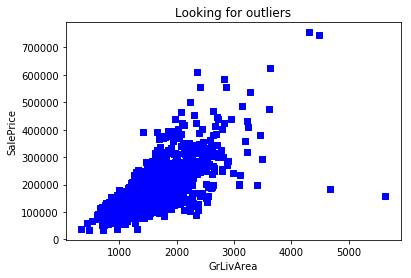

In [3]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

#Only remove entries from the training data.
tot = tot[((tot.GrLivArea < 4000) & (tot.Id < 1461)) | (tot.Id > 1460)]
m = tot.shape[0]
train = train[train.GrLivArea < 4000]
n = train.shape[0]

In [4]:
# Log transform the target for official scoring
tot[0:n].SalePrice = np.log1p(tot[0:n].SalePrice)
y = tot[0:n].SalePrice

In [5]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
tot.loc[:, "Alley"] = tot.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
tot.loc[:, "BedroomAbvGr"] = tot.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
tot.loc[:, "BsmtQual"] = tot.loc[:, "BsmtQual"].fillna("No")
tot.loc[:, "BsmtCond"] = tot.loc[:, "BsmtCond"].fillna("No")
tot.loc[:, "BsmtExposure"] = tot.loc[:, "BsmtExposure"].fillna("No")
tot.loc[:, "BsmtFinType1"] = tot.loc[:, "BsmtFinType1"].fillna("No")
tot.loc[:, "BsmtFinType2"] = tot.loc[:, "BsmtFinType2"].fillna("No")
tot.loc[:, "BsmtFullBath"] = tot.loc[:, "BsmtFullBath"].fillna(0)
tot.loc[:, "BsmtHalfBath"] = tot.loc[:, "BsmtHalfBath"].fillna(0)
tot.loc[:, "BsmtUnfSF"] = tot.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
tot.loc[:, "CentralAir"] = tot.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
tot.loc[:, "Condition1"] = tot.loc[:, "Condition1"].fillna("Norm")
tot.loc[:, "Condition2"] = tot.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
tot.loc[:, "EnclosedPorch"] = tot.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
tot.loc[:, "ExterCond"] = tot.loc[:, "ExterCond"].fillna("TA")
tot.loc[:, "ExterQual"] = tot.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
tot.loc[:, "Fence"] = tot.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
tot.loc[:, "FireplaceQu"] = tot.loc[:, "FireplaceQu"].fillna("No")
tot.loc[:, "Fireplaces"] = tot.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
tot.loc[:, "Functional"] = tot.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
tot.loc[:, "GarageType"] = tot.loc[:, "GarageType"].fillna("No")
tot.loc[:, "GarageFinish"] = tot.loc[:, "GarageFinish"].fillna("No")
tot.loc[:, "GarageQual"] = tot.loc[:, "GarageQual"].fillna("No")
tot.loc[:, "GarageCond"] = tot.loc[:, "GarageCond"].fillna("No")
tot.loc[:, "GarageArea"] = tot.loc[:, "GarageArea"].fillna(0)
tot.loc[:, "GarageCars"] = tot.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
tot.loc[:, "HalfBath"] = tot.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
tot.loc[:, "HeatingQC"] = tot.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
tot.loc[:, "KitchenAbvGr"] = tot.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
tot.loc[:, "KitchenQual"] = tot.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
tot.loc[:, "LotFrontage"] = tot.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
tot.loc[:, "LotShape"] = tot.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
tot.loc[:, "MasVnrType"] = tot.loc[:, "MasVnrType"].fillna("None")
tot.loc[:, "MasVnrArea"] = tot.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
tot.loc[:, "MiscFeature"] = tot.loc[:, "MiscFeature"].fillna("No")
tot.loc[:, "MiscVal"] = tot.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
tot.loc[:, "OpenPorchSF"] = tot.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
tot.loc[:, "PavedDrive"] = tot.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
tot.loc[:, "PoolQC"] = tot.loc[:, "PoolQC"].fillna("No")
tot.loc[:, "PoolArea"] = tot.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
tot.loc[:, "SaleCondition"] = tot.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
tot.loc[:, "ScreenPorch"] = tot.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
tot.loc[:, "TotRmsAbvGrd"] = tot.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
tot.loc[:, "Utilities"] = tot.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
tot.loc[:, "WoodDeckSF"] = tot.loc[:, "WoodDeckSF"].fillna(0)

In [6]:
# Some numerical features are actually really categories
tot = tot.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [7]:
# Encode some categorical features as ordered numbers when there is information in the order
tot = tot.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [8]:
# Create new features
# 1* Simplifications of existing features
tot["SimplOverallQual"] = tot.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
tot["SimplOverallCond"] = tot.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
tot["SimplPoolQC"] = tot.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
tot["SimplGarageCond"] = tot.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
tot["SimplGarageQual"] = tot.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
tot["SimplFireplaceQu"] = tot.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
tot["SimplFireplaceQu"] = tot.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
tot["SimplFunctional"] = tot.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
tot["SimplKitchenQual"] = tot.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
tot["SimplHeatingQC"] = tot.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
tot["SimplBsmtFinType1"] = tot.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
tot["SimplBsmtFinType2"] = tot.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
tot["SimplBsmtCond"] = tot.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
tot["SimplBsmtQual"] = tot.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
tot["SimplExterCond"] = tot.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
tot["SimplExterQual"] = tot.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
tot["OverallGrade"] = tot["OverallQual"] * tot["OverallCond"]
# Overall quality of the garage
tot["GarageGrade"] = tot["GarageQual"] * tot["GarageCond"]
# Overall quality of the exterior
tot["ExterGrade"] = tot["ExterQual"] * tot["ExterCond"]
# Overall kitchen score
tot["KitchenScore"] = tot["KitchenAbvGr"] * tot["KitchenQual"]
# Overall fireplace score
tot["FireplaceScore"] = tot["Fireplaces"] * tot["FireplaceQu"]
# Overall garage score
tot["GarageScore"] = tot["GarageArea"] * tot["GarageQual"]
# Overall pool score
tot["PoolScore"] = tot["PoolArea"] * tot["PoolQC"]
# Simplified overall quality of the house
tot["SimplOverallGrade"] = tot["SimplOverallQual"] * tot["SimplOverallCond"]
# Simplified overall quality of the exterior
tot["SimplExterGrade"] = tot["SimplExterQual"] * tot["SimplExterCond"]
# Simplified overall pool score
tot["SimplPoolScore"] = tot["PoolArea"] * tot["SimplPoolQC"]
# Simplified overall garage score
tot["SimplGarageScore"] = tot["GarageArea"] * tot["SimplGarageQual"]
# Simplified overall fireplace score
tot["SimplFireplaceScore"] = tot["Fireplaces"] * tot["SimplFireplaceQu"]
# Simplified overall kitchen score
tot["SimplKitchenScore"] = tot["KitchenAbvGr"] * tot["SimplKitchenQual"]
# Total number of bathrooms
tot["TotalBath"] = tot["BsmtFullBath"] + (0.5 * tot["BsmtHalfBath"]) + \
tot["FullBath"] + (0.5 * tot["HalfBath"])
# Total SF for house (incl. basement)
tot["AllSF"] = tot["GrLivArea"] + tot["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
tot["AllFlrsSF"] = tot["1stFlrSF"] + tot["2ndFlrSF"]
# Total SF for porch
tot["AllPorchSF"] = tot["OpenPorchSF"] + tot["EnclosedPorch"] + \
tot["3SsnPorch"] + tot["ScreenPorch"]
# Has masonry veneer or not
tot["HasMasVnr"] = tot.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
tot["BoughtOffPlan"] = tot.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [9]:
# Find most important features relative to target
print("Find most important features relative to target")
train = tot[0:n]
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
OverallQual          0.819
AllSF                0.817
AllFlrsSF            0.729
GrLivArea            0.719
SimplOverallQual     0.708
ExterQual            0.681
GarageCars           0.680
TotalBath            0.673
KitchenQual          0.667
GarageScore          0.657
GarageArea           0.655
TotalBsmtSF          0.642
SimplExterQual       0.636
SimplGarageScore     0.631
BsmtQual             0.615
1stFlrSF             0.614
SimplKitchenQual     0.610
OverallGrade         0.604
SimplBsmtQual        0.594
FullBath             0.591
YearBuilt            0.589
ExterGrade           0.587
YearRemodAdd         0.569
FireplaceQu          0.547
GarageYrBlt          0.544
TotRmsAbvGrd         0.533
SimplOverallGrade    0.527
SimplKitchenScore    0.523
FireplaceScore       0.518
                     ...  
BedroomAbvGr         0.204
AllPorchSF           0.199
LotFrontage          0.174
SimplFunctional      0.137
Functio

In [10]:
# Create new features
# 3* Polynomials on the top 10 existing features
cols = corr.SalePrice[1:11].axes
for col in cols:
  tot[col+'-2'] = tot.loc[:,col]**2
  tot[col+'-3'] = tot.loc[:,col]**3
  tot[col+'-sqrt'] = np.sqrt(np.absolute(tot.loc[:,col]))

In [11]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = tot.select_dtypes(include = ["object"]).columns
numerical_features = tot.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
tot_num = tot[numerical_features]
tot_cat = tot[categorical_features]

Numerical features : 118
Categorical features : 26


In [12]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(tot_num.isnull().values.sum()))
tot_num = tot_num.fillna(tot_num.median())
print("Remaining NAs for numerical features in train : " + str(tot_num.isnull().values.sum()))

NAs for numerical features in train : 166
Remaining NAs for numerical features in train : 0


In [13]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = tot_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
tot_num[skewed_features] = np.log1p(tot_num[skewed_features])

86 skewed numerical features to log transform


# TODO: Not sure how this works

In [14]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(tot_cat.isnull().values.sum()))
tot_cat = pd.get_dummies(tot_cat)
print("Remaining NAs for categorical features in train : " + str(tot_cat.isnull().values.sum()))

NAs for categorical features in train : 8
Remaining NAs for categorical features in train : 0


# Modelling

In [15]:
# Join categorical and numerical features
tot = pd.concat([tot_num, tot_cat], axis = 1)
print("New number of features : " + str(tot.shape[1]))

# Partition the dataset in train + validation sets
#X_train, X_test, y_train, y_test = train_test_split(tot[0:n], y, test_size = 0, random_state = 0)
X_train = tot[0:n]
y_train = train['SalePrice']
m = tot.shape[0]
X_test = tot[n:m]
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
#print("y_test : " + str(y_test.shape))

New number of features : 321
X_train : (1456, 321)
X_test : (1459, 321)
y_train : (1456,)


In [16]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [17]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [18]:
#We will use Lasso for the submission, since it gave the best results for train.csv.
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
y_train_las = lasso.predict(X_train)

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.0005099999999999999
Lasso RMSE on Training set : 0.10752643237754296


In [29]:
pred = np.exp(lasso.predict(X_test))-1
submit = pd.DataFrame({'Id': np.arange(1461, 1461+ m - n), 'SalePrice' : pred})
submit.to_csv('28022019.csv', index=False)